In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("covid_part2.ipynb")

# Final Project: COVID-19 Dataset
## Exploring COVID-19 Data through Modeling
## Due Date: Thursday, December 13th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.


## This Assignment

In this final project, we will investigate COVID-19 data over the past year. This data contains information about COVID-19 case counts, mortalities, vaccination rates, and various other metadata that can assist in modeling various aspects of COVID-19.

Through this final project, you will demonstrate your experience with:
* Data cleaning and EDA using Pandas
* Unsupervised and supervised learning techniques
* Visualization


## Goal

Model and analyze the temporal evolution of COVID-19 mortalities or cases using one unsupervised and one supervised technique of your choice. Interpret your models' results through visualizations, and draw insightful conclusions about the modeling of COVID-19 data.

Recall that we studied linear and logistic regression, decision trees, random forests as part of supervised learning (with labels) and clustering, PCA as part of unsupervised learning (without labels). You are free to use any methods that you find suitable to answer the problem at hand.

In [2]:
# Run this cell to set up your notebook
import numpy as np
from geopy import *
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import *
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
import re

cases = pd.read_csv('data/time_series_covid19_confirmed_US.csv') # https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
vaccinations = pd.read_csv('data/people_vaccinated_us_timeline.csv') # https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/people_vaccinated_us_timeline.csv
counties = pd.read_csv('data/co-est2020.csv', encoding='latin-1') # https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/co-est2020.csv
mask_use = pd.read_csv('data/mask-use-by-county.csv') # https://github.com/nytimes/covid-19-data/blob/master/mask-use/mask-use-by-county.csv

<br/><br/><br/>

---

<br/><br/><br/>

## Data Cleaning (Again!)

For this section, please copy over the appropriate answers from your previous notebook submission.

### Part 1: Question 1a

Impute the null values in *all* the datasets with zero values or empty strings where appropriate.

<!--
BEGIN QUESTION
name: q1a
points: 0
-->

In [3]:
vaccinations[['FIPS', 'Lat', 'Long_', 'People_Fully_Vaccinated','People_Partially_Vaccinated']] = vaccinations[['FIPS','Lat', 'Long_', 'People_Fully_Vaccinated','People_Partially_Vaccinated']].fillna(0)
cases[['FIPS']] = cases[['FIPS']].fillna(0)
cases[['Admin2']] = cases[['Admin2']].fillna('')

In [4]:
grader.check("q1a")

q1a results: All test cases passed!

### Part 1: Question 1d

Generate a valid FIPS code for the `counties` table.

*Hint*: Refer to [this](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt) guide on FIPS codes.

<!--
BEGIN QUESTION
name: q1d
points: 0
-->

In [5]:
counties['FIPS'] = counties['STATE'].map("{:02}".format) + counties['COUNTY'].map("{:03}".format)
counties['FIPS'] = counties['FIPS'].astype(float)
counties.head()

SUMLEV  REGION  DIVISION  STATE  COUNTY   STNAME         CTYNAME  \
0      40       3         6      1       0  Alabama         Alabama   
1      50       3         6      1       1  Alabama  Autauga County   
2      50       3         6      1       3  Alabama  Baldwin County   
3      50       3         6      1       5  Alabama  Barbour County   
4      50       3         6      1       7  Alabama     Bibb County   

  CENSUS2010POP  ESTIMATESBASE2010  POPESTIMATE2010  ...  POPESTIMATE2013  \
0       4779736            4780118          4785514  ...          4831586   
1         54571              54582            54761  ...            54747   
2        182265             182263           183121  ...           194978   
3         27457              27454            27325  ...            26946   
4         22915              22904            22858  ...            22510   

   POPESTIMATE2014  POPESTIMATE2015  POPESTIMATE2016  POPESTIMATE2017  \
0          4843737          4854803          4866824          4877989   
1            54922            54903            55302            55448   
2           199306           203101           207787           212737   
3            26768            26300            25828            25169   
4            22541            22553            22590            22532   

   POPESTIMATE2018  POPESTIMATE2019  POPESTIMATE042020  POPESTIMATE2020  \
0          4891628          4907965            4920706          4921532   
1            55533            55769              56130            56145   
2           218071           223565             227989           229287   
3            24887            24657              24652            24589   
4            22300            22313              22199            22136   

     FIPS  
0  1000.0  
1  1001.0  
2  1003.0  
3  1005.0  
4  1007.0  

[5 rows x 22 columns]

In [6]:
grader.check("q1d")

q1d results: All test cases passed!

### Part 1: Question 1e

Merge the `counties`, `cases`, and `mask_use` tables on an appropriate primary key to generate county-wise data.

<!--
BEGIN QUESTION
name: q1e
points: 0
-->

In [7]:
mask_use['COUNTYFP'] = mask_use['COUNTYFP'].astype(float)
county_data = cases.merge(counties, how = "inner", on = "FIPS").merge(mask_use, how = "inner", left_on="FIPS", right_on="COUNTYFP")
county_data.head()

UID iso2 iso3  code3    FIPS   Admin2 Province_State Country_Region  \
0  84001001   US  USA    840  1001.0  Autauga        Alabama             US   
1  84001003   US  USA    840  1003.0  Baldwin        Alabama             US   
2  84001005   US  USA    840  1005.0  Barbour        Alabama             US   
3  84001007   US  USA    840  1007.0     Bibb        Alabama             US   
4  84001009   US  USA    840  1009.0   Blount        Alabama             US   

         Lat      Long_  ... POPESTIMATE2018  POPESTIMATE2019  \
0  32.539527 -86.644082  ...           55533            55769   
1  30.727750 -87.722071  ...          218071           223565   
2  31.868263 -85.387129  ...           24887            24657   
3  32.996421 -87.125115  ...           22300            22313   
4  33.982109 -86.567906  ...           57770            57840   

   POPESTIMATE042020  POPESTIMATE2020  COUNTYFP  NEVER  RARELY  SOMETIMES  \
0              56130            56145    1001.0  0.053   0.074      0.134   
1             227989           229287    1003.0  0.083   0.059      0.098   
2              24652            24589    1005.0  0.067   0.121      0.120   
3              22199            22136    1007.0  0.020   0.034      0.096   
4              57932            57879    1009.0  0.053   0.114      0.180   

   FREQUENTLY  ALWAYS  
0       0.295   0.444  
1       0.323   0.436  
2       0.201   0.491  
3       0.278   0.572  
4       0.194   0.459  

[5 rows x 638 columns]

In [8]:
grader.check("q1e")

q1e results: All test cases passed!

<br/><br/><br/>

---

<br/><br/><br/>

## Question 5: Guided Supervised Modeling

This section will guide you through creating a supervised learning framework that will predict the number of COVID-19 cases per capita given various COVID-19 safety protocols that have been implemented. Then, we will investigate the bias, variance, and observational noise of this framework.

Note that any answer responses without the appropriate work (i.e. code or math) will be subject to additional review and will not receive any credit.

<!-- BEGIN QUESTION -->

### Question 5a

We will use county-wise mask usage data to predict the number of COVID-19 cases on September 12th, 2021. Create a visualization that shows the pairwise correlation between each combination of column in the mask usage data and the number of COVID-19 cases.

*Hint*: You should be plotting 36 correlations.
<!--
BEGIN QUESTION
name: q5a
points: 3
manual: True
-->

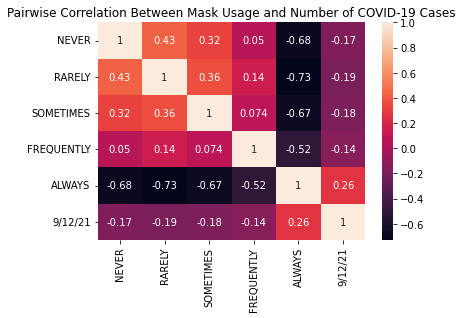

In [9]:
#county_data["case_capita_9/12/21"] = county_data[["9/12/21"]] / county_data[["POPESTIMATE2020"]].to_numpy()
q5a_df = county_data[["NEVER", "RARELY", "SOMETIMES", "FREQUENTLY", "ALWAYS", "9/12/21"]]


sns.heatmap(q5a_df.corr(), annot=True)
plt.title("Pairwise Correlation Between Mask Usage and Number of COVID-19 Cases");

<!-- END QUESTION -->

### Question 5b

Train a linear regression model to predict the number of COVID-19 cases using county-wise mask usage data for September 12, 2021. Evaluate your model's RMSE on a held-out validation set with 33% of the county-wise data. When possible, make sure to set `random_state = 42` when splitting your data into training and test sets.
<!--
BEGIN QUESTION
name: q5b
points: 5
-->

In [10]:
X_q5b = q5a_df.drop(columns = {"9/12/21"})
y_q5b = pd.Series(q5a_df["9/12/21"]) #actual COVID cases

# Make sure to set random_state = 42 and test_size = 0.33!
X_q5b_train, X_q5b_test, y_q5b_train, y_q5b_test = train_test_split(X_q5b, y_q5b, test_size=0.33, random_state = 42)

linear_model = LinearRegression()
linear_model.fit(X = X_q5b_train, y = y_q5b_train)

#define rmse function
def rmse(actual_y, predicted_y):
    return np.sqrt(np.mean((actual_y - predicted_y)**2))

train_rmse_cases = rmse(y_q5b_train, linear_model.predict(X_q5b_train)) 
test_rmse_cases = rmse(y_q5b_test, linear_model.predict(X_q5b_test))

train_rmse_cases, test_rmse_cases

(28745.116729283855, 61671.75722098981)

In [11]:
grader.check("q5b")

q5b results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5c

Explain potential reasons the test set RMSE is much higher as compared to the training set RMSE.
<!--
BEGIN QUESTION
name: q5c
points: 3
manual: True
-->

_Some potential reasons as to why the test RMSE is much higher compared to the training set RMSE could be that our model overfit our training set, thus our test set would have more unpredictable/unknown values, causing a higher rmse. Another reason could be that since we are just looking at overall COVID cases rather than cases per capita, our margin of error could be much larger since there isn't a standard/consistent measure and the COVID cases of larger counties could be seem more out of proportion than smaller counties, thus throwing off our calculations and predictions._

<!-- END QUESTION -->

### Question 5d

Instead of predicting the number of COVID-19 cases, redo part (b) by predicting the number of cases per capita. Report the model's RMSE on the training and validation set.

Comment on the relationship between the training and test RMSE by predicting the number of cases per capita instead of the total number of cases.
<!--
BEGIN QUESTION
name: q5d
points: 3
-->

In [12]:
q5d_df = q5a_df.copy().drop(columns = {"9/12/21"})
q5d_df["9/12/21_Cases_Per_Capita"] = q5a_df["9/12/21"] / county_data["POPESTIMATE2020"]

##Original starts here 
X_q5d = q5d_df.drop(columns = {"9/12/21_Cases_Per_Capita"})
y_q5d = pd.Series(q5d_df["9/12/21_Cases_Per_Capita"]) 
X_q5d_train, X_q5d_test, y_q5d_train, y_q5d_test = train_test_split(X_q5d, y_q5d, test_size=0.33, random_state = 42)

#Define 2nd model
linear_model_2 = LinearRegression()
linear_model_2.fit(X = X_q5d, y = y_q5d)

train_rmse_cpc = rmse(y_q5d_train, linear_model_2.predict(X_q5d_train)) 
test_rmse_cpc = rmse(y_q5d_test, linear_model_2.predict(X_q5d_test))


train_rmse_cpc, test_rmse_cpc

(0.03553147592552991, 0.03791719933949232)

In [13]:
grader.check("q5d")

q5d results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5e

Visualize the model outputs from part (d) by plotting the predictions $\hat{y}$ versus the observations $y$. Comment on what the plot indicates about our linear model as a comment in the code cell.

<!--
BEGIN QUESTION
name: q5e
points: 3
manual: True
-->

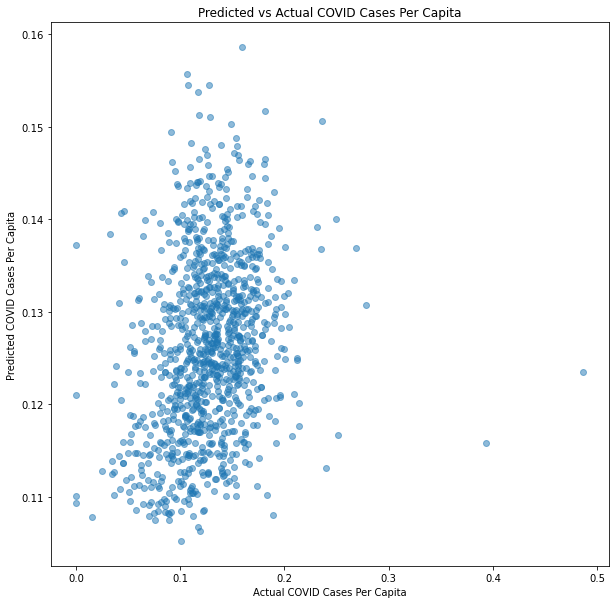

In [14]:
#Use the test set.
Y_pred_q5d = linear_model_2.predict(X_q5d_test)
plt.figure(figsize=(10, 10))
plt.scatter(y_q5d_test, Y_pred_q5d, alpha=0.5)
plt.xlabel("Actual COVID Cases Per Capita")
plt.ylabel("Predicted COVID Cases Per Capita")
plt.title("Predicted vs Actual COVID Cases Per Capita");

#Our plot indicates that our linear model is pretty consistent and accurate with predicting the actual COVID cases per capita.
#As we see below, there are very few outliers in the chart, and majority of the predictions fall in the 0.1 - 0.2 range,
#which is actually very close to normal (off by only roughly 1-4%). 

<!-- END QUESTION -->

### Question 5f

We will investigate the bias and variance of this improved model on the test set using the bias-variance decomposition to formalize the behaviour of our model. To generate an empirical estimate of the errors and the parameters in the bias-variance decomposition, train 1000 bootstrapped models on the training dataset from part (d).

<!--
BEGIN QUESTION
name: q5f
points: 5
-->

In [15]:
#CHECK: How many samples needed?
#Train 1000 bootstrapped models on the training dataset from part

q5f_df = X_q5d_train.copy()
q5f_df["9/12/21_Cases_Per_Capita"] = y_q5d_train

models = []
for i in range(1000):
    #Sample randomly
    sample_size = len(q5d_df)
    sample_df = q5f_df.sample(n = sample_size, replace = True) #how large should sample size be?
    
    X_q5f = sample_df.drop(columns = {"9/12/21_Cases_Per_Capita"})
    y_q5f = pd.Series(sample_df["9/12/21_Cases_Per_Capita"]) 

        
    #train model and append??
    #X_q5f_train, X_q5f_test, y_q5f_train, y_q5f_test = train_test_split(X_q5f, Y_q5f, test_size=0.33, random_state = 42)
    
    #train on test set??
    m = LinearRegression()
    m.fit(X = X_q5f, y = y_q5f)
    
    models.append(m)
    

In [16]:
grader.check("q5f")

q5f results: All test cases passed!

### Question 5g

To investigate the variance in our test predictions, we sample a particular test point $(x_i, y_i)$ such that $i = 100$. In other words, we will use the 100th point in the test set from part (d), `(X_q5d_test.iloc[100], y_q5d_test.iloc[100])` as the testing point.

Generate predictions and square errors for this test point for all 1000 models, and calculate the *proportion* of the *expected* square error that is captured by the model prediction variance. In other words, we wish to estimate the following quantity:

$$
\frac{\mathrm{Var}(f_\theta(x_i))}{\mathrm{E}_\theta[(y_i - f_\theta(x_i))^2]}
$$

*Hint*: Refer to the bias-variance decomposition from lecture.
<!--
BEGIN QUESTION
name: q5g
points: 5
-->

In [17]:
X_testp, y_testp = np.array(X_q5d_test.iloc[100]).reshape(1,-1), np.array(y_q5d_test.iloc[100]).reshape(1,-1)

model_var = []

model_se = []
model_v = []


def se(y,yhat):
    
    return (y-yhat)**2


for m in models:

    y_pred5g = m.predict(X_testp)
    
    model_se.append(np.mean(se(y_testp, y_pred5g)))
    model_var.append(y_pred5g)
    model_v.append(np.var(y_pred5g)/ np.mean(se(y_testp, y_pred5g)))
 
    
bias = np.mean(model_se)
variance = np.var(model_var)
    

prop_var = variance/bias


prop_var

0.0008933908851729511

In [18]:
grader.check("q5g")

q5g results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5h

Using the bias-variance decomposition, comment on how much the variance of the model contributes to the error on the sample point above. We will extend this scenario to analyze the noise term in the bias-variance decomposition, specifically with regards to this COVID-19 dataset. Consider the following:

i) Assuming no observational noise (i.e. $\epsilon = 0$), what is the *magnitude* of the empirical model bias on this sample point?

ii) Clearly, there is a non-trivial amount of observational noise with COVID-19 case data simply due to how testing works and occurs. Please take a look at [this article](https://fivethirtyeight.com/features/coronavirus-case-counts-are-meaningless/) for more information. Given this infomation, explain the issues with the assumptions and result in 5h(i).

iii) Recall that we typically assume $y = g(x) + \epsilon$, where $\epsilon \sim \mathcal{N}(\mu, \sigma)$. In the theoretical setting for bias-variance, we have assumed $\mu = 0, \sigma > 0$. In this practical setting, analyze and determine how $\epsilon$ could be modeled (as a normal distribution, but you may also consider how it could be modeled as another distribution). Are there any immediate issues with the assumptions we have made in the theoretical setting where $\mu = 0, \sigma > 0$? What conditions on $\mu, \sigma$ could be more appropriate and why?

iv) Does the standard bias-variance decomposition presented in lecture hold given $\epsilon$ being normally distributed according to your answer in part (iii)? If so, please explain why. If not, explain why it does not hold and if possible, how to modify the bias-variance decomposition to make it hold (i.e. perhaps there is an additional noise term $E[\epsilon^3]$). 

*Hint*: Try to express $y = g(x) + \epsilon$ by adding and subtracting a certain quantity.

v) Intuitively, is it possible to minimize the true model bias to 0 given your $\epsilon$ formulation in part (iii)? Why or why not? Justify your answer using part (iv) if possible.

vi) Consider the infinite sample case where an oracle grants you as many samples as requested, and answer the same question in part (v). Is it possible to minimize the true model bias to 0 given your $\epsilon$ formulation in part (iii)? Conclude with an analysis of what our modeling task can approximate using $X\theta \approx y$ in the finite and infinite sample case.

<!--
BEGIN QUESTION
name: q5h
points: 24
manual: True
-->

## ==================================================================================
### Solution 5h
i)

$E[(y - f_\theta(x)^2] = \sigma^2 + var[f_\theta(x)] + E([f_\theta(x)] -g(x))^2$
  
$0.01421948489254234 = 0^2 + 2.8257176360761626e-06 + (Bias)^2$
  
$Bias = 0.1192336327338317 $
  
  
-------------------------------------------------------------------------------------

ii)
* Based on the article, there will always be a noise where in our case it is referred as the error rate of determining the true values of COVID Cases.
* And this can happen in one of the different four ways described in the reading. 
* So, in order to be able to predict the exact number of cases, we may need to consider the testing methods of all hospitals in a given areaand then we can track the movement of every Covid patient. 
* However, noice/error is usually inevitable as long as there will be a difference in the number of Covid cases in reality versus on paper. 



iii)

For this part we assumed $\epsilon$ takes the normal distribution and it has $\mu = 0$ and $\sigma > \mu$. Hence, in contrast with a how normal graph looks like  $\mu = 0$, we will end up having a noise $\epsilon = 0$. This contradicts with what we have said in part ii) and leads us to conclude saying it is very unlikely to predict the true values of COVID Cases. Therefore, we can never have $\epsilon = 0$ and a reasonable value for this senario seems to be $0 < \mu < \sigma$. 


-------------------------------------------------------------------------------------

iv) 

We have: 
$y = g(x) + \epsilon$

We know that  $\epsilon ~ N(\mu, \sigma)$  and  $\epsilon$ != $0$. So, after plugging in $\mu$:

$y = g(x) + \mu - \epsilon$



Now, let's assume: 
$g^{'}(x) = g(x) + \mu$

---> $\epsilon^{'} = \epsilon - \mu$

---> $y = g^{'}(x) + \epsilon^{'}$


Now: $MSE = E((y - \hat{y})^2)$

$  = E(((g^{'}(x) + \epsilon^{'}) - \hat{y})^2)$

$  = E((\epsilon^{'} + (g^{'}(x) - \hat{y}))^2)$

$ = E(\epsilon^{'})^2 + 2E(\epsilon^{'}(g^{'}(x) - \hat{y})) + E(g^{'}(x) - \hat{y})^2$

$ = E(\epsilon^{'})^2 + (g^{'}(x) - (E(\hat{y}(x))))^2 + E(E(g^{'}(x) - \hat{y})^2)$

$ = 0^2 + (g(x) + \mu - E(\hat{y}(x)))^2 +E(E(g^{'} - \hat{y})^2)$

* $Observed-Variance = 0^2$
* $(Model-Bias)^2 = g(x) + \mu - E(\hat{y}(x)))^2$
* $Model - Variance = E(E(g^{'} - \hat{y})^2)$



-------------------------------------------------------------------------------------

v)

From part iii) we said we can have $\mu > 0$ and we stated that we cannot completely reduce the noise. Therefore, $\mu$ !=  $0$ since we have a finite samples.


-------------------------------------------------------------------------------------

vi)

Given that the sample is infinite, we can take the limit as we approach 0. With all the given collection of samples we may take off all the noise and get the true actual value. 













<!-- END QUESTION -->

### Question 5i

Using the bias-variance decomposition for each test point, calculate the average variance and average test mean-square error across the entire test set from part (d). In other words, estimate the following quantities:

$$
\frac{1}{n} \sum_i \mathrm{Var}(f_\theta(x_i))
$$

and

$$
\frac{1}{n} \sum_i \mathrm{E}_\theta[(y_i - f_\theta(x_i))^2]
$$

<!--
BEGIN QUESTION
name: q5i
points: 5
manual: False
-->

In [19]:
test_se = []
test_var = []

def se(y, yhat):
    return (y - yhat)**2


#sample_points = np.random.randint(len(X_q5d_test), size=100) #"@1985_f13 --> you may sample 100-250 data points out of the 1037 test points."
sample_points = np.arange(len(X_q5d_test)) #Takes a while to run but works!

for m in models:
    test_pred = []
    for i in sample_points: #go over each test point
        X_p, Y_p = np.array(X_q5d_test.iloc[i]).reshape(1, -1), np.array(y_q5d_test.iloc[i]).reshape(1, -1)
        y_pred5i = m.predict(X_p)  #predict y
        test_se.append(se(Y_p, y_pred5i)) #get the error and append
        test_pred.append(y_pred5i) #append prediction
        
    test_var.append(test_pred) #append to an array, which we will later transform into a dataframe to get var since np.var too long runtime


#avg_var, avg_mse = np.mean(test_var), np.mean(test_se)
#avg_var, avg_mse

x = pd.DataFrame(test_var) #turn into a df

avg_var, avg_mse =  np.mean(x.var()), np.mean(test_se)
avg_var, avg_mse

(2.595765960269871e-06, 0.0014429836597926828)

In [20]:
grader.check("q5i")

q5i results: All test cases passed!

<!-- BEGIN QUESTION -->

## Question 5j

Propose a solution to reducing the mean square error using the insights gained from the bias-variance decomposition above. What are the values of the quantities that have we estimated and what can be concluded about the remaining quantities? Please show all work that informs your analysis.

Assume that the standard bias-variance decomposition used in lecture can be applied here.
<!--
BEGIN QUESTION
name: q5j
points: 5
manual: True
-->

_Since we do not know what the observation variance is we can attempt to focus on our model variance and model bias. In terms to reduce model risk we can reduce our bias as the average variance in 5i is a low number. By reducing bias there is a small chance to increasing variance but it will be fine to do. Our model risk is the average mse in 5i (0.0014432240920804397) where our average variance is 2.6351243075690822e-06. For our model bias, we can conclude that it will be higher than the average variance as our avergae variance is so low and in 5h we prove it cannot be 0 but greater than 0. This means we are overestimating at x since we conclude it will be a positive value._

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Question 6: Open Supervised Modeling

We wish to extend our modeling framework from Question 5 to make it more accurate; in other words, we wish to predict $f(x)$, a supervised learning output, based on past and current quantities. 

This section will serve as a rough guide on creating an autoregressive modeling framework for predicting a COVID-19 quantity of your choice (i.e. deaths, cases, vaccinations).

Note that if you do not wish to pursue time-based modeling of COVID-19, you may skip parts (d), (e), and (f). That being said, you are strongly encouraged to incorporate time-based modeling into your open-ended modeling design since it constitutes a large component of the provided datasets.

We will ***not*** grade these below questions individually (i.e. there are no points explicitly assigned to questions 6(a) to 6(f)); they are simply guiding questions and will be graded as part of the final project report. You should make sure to answer all of the questions (that are applicable to your open-ended modeling) in some form in the report.

<!-- BEGIN QUESTION -->

### Question 6a

Train a baseline model where $f$ is the model described in Question 0a and $x$ is a quantity of *your* choice. Note that you may used *any* supervised learning approach we have studied; you are not limited to a linear model.

<!--
BEGIN QUESTION
name: q6a
points: 0
manual: True
-->

In [21]:
#Merge external dataset
urlx = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
d = pd.read_csv(urlx,index_col=0,parse_dates=[0]).reset_index().add_prefix('death_') #new deaths
deaths = d.merge(county_data.add_prefix('cases_'), left_on = "death_FIPS", right_on = "cases_FIPS")



### Open-Ended EDA 

_Here we explore relationships between COVID deaths and COVID cases_

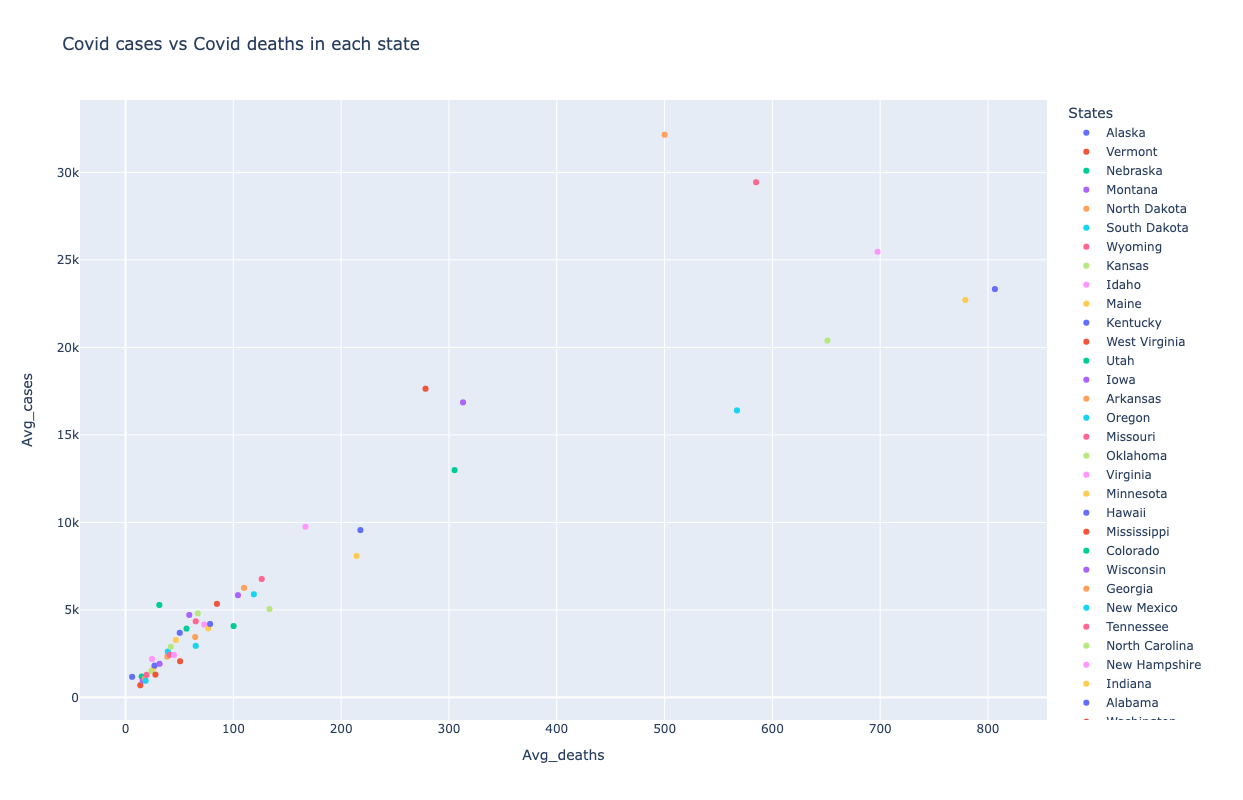

In [22]:
#bivariate: COVID cases per State and COVID deaths per State?

d_start = deaths.columns.get_loc('death_1/22/20')
d_end = deaths.columns.get_loc('death_9/12/21')
c_start = county_data.columns.get_loc("1/22/20")
c_end = county_data.columns.get_loc("9/12/21")

new_deaths_and_cases_df = deaths[['death_Province_State', 'death_Admin2']].rename(columns={'death_Province_State' : 'States', 'death_Admin2': 'Admin'})
new_deaths_and_cases_df['Avg_deaths'] = deaths.iloc[:, d_start: d_end + 1].reset_index().mean(axis=1)
new_deaths_and_cases_df['Avg_cases'] = county_data.iloc[:, c_start: c_end + 1].reset_index().mean(axis=1)
new_deaths_and_cases_df = new_deaths_and_cases_df.groupby('States').mean()

cases_vs_deaths = px.scatter(new_deaths_and_cases_df.reset_index().sort_values(by = "Avg_deaths")
                  , y="Avg_cases", x="Avg_deaths", color= "States", width=1200, height=800,
                 title = "Covid cases vs Covid deaths in each state")

cases_vs_deaths.show()

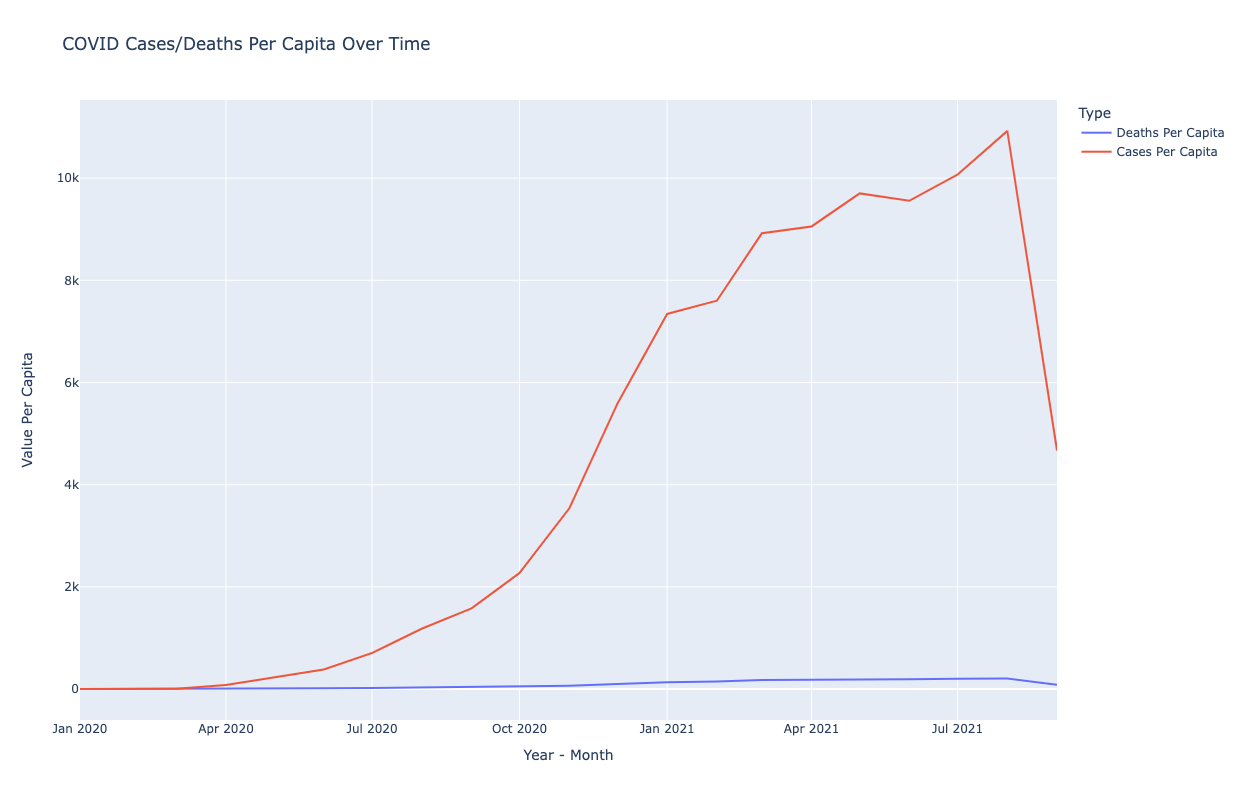

In [23]:
#bivariate: COVID Deaths/Cases As Function of Time


#Get Cases By Month/Year
cases_by_date = deaths.loc[:, "cases_1/22/20": "cases_9/12/21"] / deaths[["cases_POPESTIMATE2020"]].to_numpy() 
cases_by_date = cases_by_date.join(deaths[["cases_CTYNAME"]])
cases_by_date = cases_by_date.groupby("cases_CTYNAME").sum() 


inter_case = cases_by_date.transpose().sum(axis = 1).reset_index().rename(columns = {"index" : "Date", 0: "Cases Per Capita"})
inter_case["Month/Year"] = inter_case["Month/Year"] = "20" + inter_case["Date"].astype(str).str.split("/").str.get(2
                                ) + "-" + inter_case["Date"].astype(str).str.split("_").str.get(1).str.split("/").str.get(0)
inter_case = inter_case.groupby("Month/Year").sum()#.reset_index()


#Get Deaths by Month/Year
deaths_by_date = deaths.loc[:, "death_1/22/20": "death_9/12/21"] / deaths[["cases_POPESTIMATE2020"]].to_numpy() 
deaths_by_date = deaths_by_date.join(deaths[["cases_CTYNAME"]])
deaths_by_date = deaths_by_date.groupby("cases_CTYNAME").sum() 

inter_death = deaths_by_date.transpose().sum(axis = 1).reset_index().rename(columns = {"index" : "Date", 0: "Deaths Per Capita"})
inter_death["Month/Year"] = inter_death["Month/Year"] = "20" + inter_death["Date"].astype(str).str.split("/").str.get(2
                                ) + "-" + inter_death["Date"].astype(str).str.split("_").str.get(1).str.split("/").str.get(0)

inter_death = inter_death.groupby("Month/Year").sum()#.reset_index()


all_joined = inter_death.join(inter_case).reset_index()
all_joined['datetimes'] = pd.to_datetime(all_joined["Month/Year"])
all_joined = all_joined.sort_values('datetimes').drop(columns = ["datetimes"]).rename(columns = {"Month/Year": "Year - Month"})#.set_index("Year - Month")






final_all_joined = all_joined.melt("Year - Month").rename(columns = {"variable": "Type", "value" : "Value Per Capita"})
px.line(final_all_joined, x = "Year - Month", y = "Value Per Capita", 
        color = "Type", height = 800, title = "COVID Cases/Deaths Per Capita Over Time")



### Hypothesis Testing

_Here we test our hypothesis: We expect that states that have a higher proportion of COVID cases per capita will have a HIGHER COVID death rate per capita_

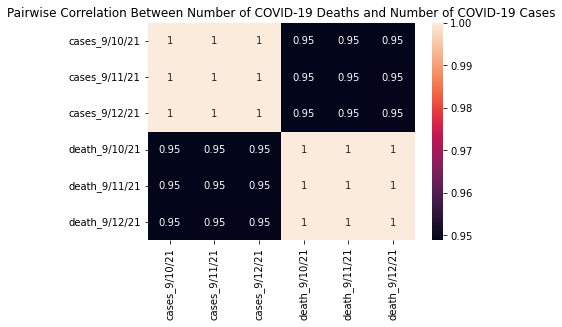

In [24]:
#See if there is any correlation between COVID cases and COVID deaths (let's look at just 2 days)

initial_df = deaths[["cases_9/10/21", "cases_9/11/21", "cases_9/12/21","death_9/10/21",
                    "death_9/11/21", "death_9/12/21"]]
sns.heatmap(initial_df.corr(), annot=True)
plt.title("Pairwise Correlation Between Number of COVID-19 Deaths and Number of COVID-19 Cases");

_There seems to be a positive correlation between deaths and covid-19 cases_

Let's confirm/reject it using a p-value test

We'll do this by calculating the correlation coefficient for the sum of COVID cases/deaths in the same timeframe (1/22/20 - 9/12/21) and using scipy's stats (pearsonr) to calculate the p-value.

__Null Hypothesis:__ COVID cases per Capita HAVE NO EFFECT COVID deaths

__Alternate Hypothesis:__ States that have a higher COVID cases per Capita WILL have higher COVID deaths

In [26]:
#Calculate correlation Coefficient for Each Value For initial df

cse = deaths.loc[:, "cases_1/22/20" : "cases_9/12/21"].sum(axis = 1)
dthe = deaths.loc[:, "death_1/22/20" : "death_9/12/21"].sum(axis = 1)
new_df = pd.DataFrame({"Total_Cases_Per_Capita" : cse, "Total_Deaths_Per_Capita" : dthe})  
new_df = new_df/deaths[["cases_POPESTIMATE2020"]].to_numpy()


new_df.head()

Total_Cases_Per_Capita  Total_Deaths_Per_Capita
0               37.767441                 0.551910
1               29.471462                 0.382900
2               31.013299                 0.649152
3               37.250542                 0.821964
4               35.660343                 0.631835

In [27]:
correlation_coefficient, p_value = pearsonr(new_df["Total_Cases_Per_Capita"], new_df["Total_Deaths_Per_Capita"])
print("Our p-value of {} is < 0.0001: ".format(p_value), p_value < 0.05)
print("Our correlation_coefficient is {} ".format(correlation_coefficient))

Our p-value of 9.147392943409575e-234 is < 0.0001:  True
Our correlation_coefficient is 0.5365877734187152 


### Results of P-value Test

_Since our p-value is < 0.0001, we can conclude that there is a STRONG correlation between COVID-19 cases and COVID-19 deaths per capita. Hence, we will continue with our model to predict COVID deaths per capita based on COVID cases per capita._

### Our Baseline Model:

* Use COVID cases history to predict deaths

Baseline Model: $f_\theta(x) = \theta_0 + \theta_1x_1$, where $x_1$ is the COVID cases per capita of the most recent day in our dataset


In [28]:
base_model = deaths[["cases_9/12/21", "death_9/12/21"]] / deaths[["cases_POPESTIMATE2020"]].to_numpy()

X_death = base_model.drop(columns = {"death_9/12/21"})
y_death = pd.Series(base_model["death_9/12/21"])

X_death_train, X_death_test, y_death_train, y_death_test = train_test_split(X_death, y_death)


lr_death = LinearRegression()
lr_death.fit(X = X_death, y = y_death)

train_death_rmse = rmse(y_death_train, lr_death.predict(X_death_train)) 
test_death_rmse = rmse(y_death_test, lr_death.predict(X_death_test))

print("Training RMSE", train_death_rmse)
print("Testing RMSE", test_death_rmse)

Training RMSE 0.0010595322115687965
Testing RMSE 0.0010702573171109196


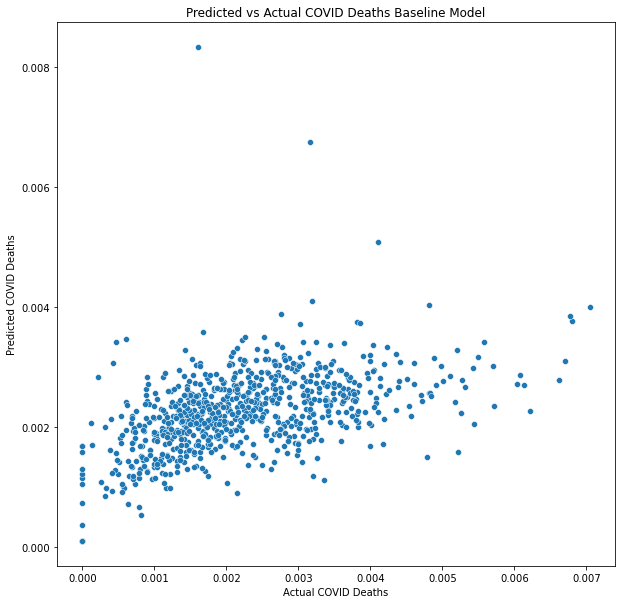

In [29]:
y_pred_death_test = lr_death.predict(X_death_test)
plt.figure(figsize=(10, 10))
sns.scatterplot(y_death_test, y_pred_death_test)
plt.xlabel("Actual COVID Deaths")
plt.ylabel("Predicted COVID Deaths")
plt.title("Predicted vs Actual COVID Deaths Baseline Model");


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6b

Improve your model from part (a). Specify the supervised model you choose and write $f(x)$ as a function of the chosen features and parameters in your model. Justify why you chose these features and how you expect they will correlate with the output you wish to predict.

<!--
BEGIN QUESTION
name: q6b
points: 0
manual: True
-->

In [30]:
start_2 = deaths.columns.get_loc("cases_1/22/20") #earliest date in dataset
end_2 = deaths.columns.get_loc("cases_9/12/21") + 1

improved_time_death_cases = deaths.iloc[:, start_2:end_2]
improved_time_death_cases["Deaths"] = deaths["death_9/12/21"]

improved_time_death_cases = improved_time_death_cases/deaths[["cases_POPESTIMATE2020"]].to_numpy()

#Create a New Model
X_death_new = improved_time_death_cases.drop(columns = {"Deaths"})
y_death_new = pd.Series(improved_time_death_cases["Deaths"])

X_death_train_new, X_death_test_new, y_death_train_new, y_death_test_new = train_test_split(X_death_new, y_death_new, test_size=0.33, random_state=42)

lr_death_new = LinearRegression()
lr_death_new.fit(X = X_death_new, y = y_death_new)

train_death_rmse_new = rmse(y_death_train_new, lr_death_new.predict(X_death_train_new)) 
test_death_rmse_new = rmse(y_death_test_new, lr_death_new.predict(X_death_test_new))

print("Training RMSE", train_death_rmse_new)
print("Testing RMSE", test_death_rmse_new)

Training RMSE 0.000783992828697602
Testing RMSE 0.0007722374337294707


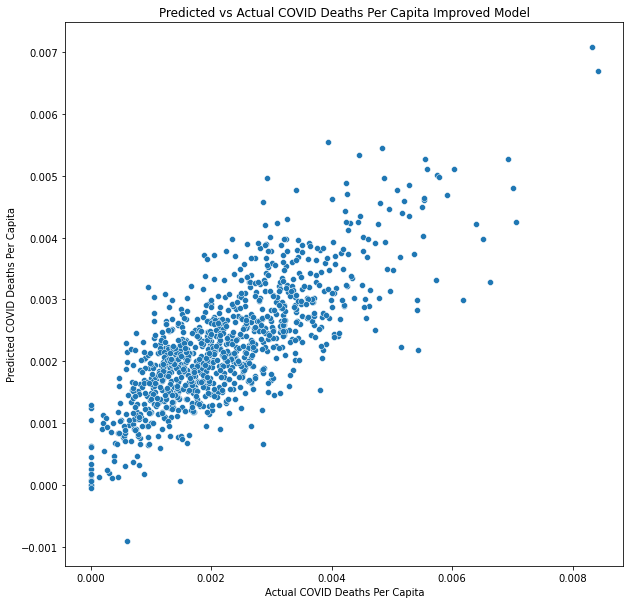

In [31]:
y_pred_death_test_new = lr_death_new.predict(X_death_test_new)
plt.figure(figsize=(10, 10))
sns.scatterplot(y_death_test_new, y_pred_death_test_new)
plt.xlabel("Actual COVID Deaths Per Capita")
plt.ylabel("Predicted COVID Deaths Per Capita")
plt.title("Predicted vs Actual COVID Deaths Per Capita Improved Model");


__Our Commentary:__

We improved our model by selecting a larger time range (before we were looking at the COVID cases per capita for the most recent day, now we're looking at all the dates in the county_data dataset, so roughly a little more than 1.5 years of COVID cases).

We chose to incorporate a larger time range since the more COVID cases data is given to the model, the better it will be able to predict COVID deaths. We also decided to convert everything to _per capita_ for more accurate results as we saw earlier in the guided modeling, using _per capita_ signficantly reduced RMSE since it standardized COVID cases to a certain scale.


_Function of the Features For Our New Multiple Linear Regression Model:_

$f_\theta(x)$ = $\theta_0$ + $\theta_1x_{t}$ + $\theta_2x_{t - 2}$ + ... + $\theta_kx_{t - k}$ 
where $k$ is the number of timesteps in our cases data, and $t$ is the beginning of our time data (1/22/20)





<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6c

If applicable, write an equation or rule for the prediction function $f(x)$; if this is infeasible, make sure to visualize your model parameters in some way. Interpret your improved model's optimal parameters (*hint*: refer to 1aiii), and compare these parameters to those of the baseline model. Comment on whether the parameters follow physical intuition given the nature of the prediction task.

For example, if you chose to use a decision tree, you may interpret the generated rules.
 
<!--
BEGIN QUESTION
name: q6c
points: 0
manual: True
-->

_$x_{t+1}= \hat{\theta}_0 \sum\limits{i=0}^t  + {\hat{\theta}_1}^ {i}  + {\hat{\theta}_1}^ {t+1} x_0$_


Our improved model's parameters include a much more comprehensive past COVID cases per capita data as it includes all days of COVID cases data in our dataset. In our baseline model, we only had 1 $x$ parameter, while in our new one we have as many $x$ paramters as dates for COVID cases in our dataset.

Our parameters follow a more scientific/analytic intuition as compared to a physical intution since our model uses these paramters to determine the correct weights needed to predict the COVID deaths per capita of the next day.


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6d

Discuss your improved model's performance on both short-term and long-term time scales using a metric of your choice (*hint:* we're using an autoregressive model). In other words, given $x_t$, we wish to predict $\hat{x}_{t+k}$, and plot the error of these predictions for two $k$ values of your choice. You may use any reasonable interpretation of short-term and long-term predictions; an initial suggestion is to use 2-day predictions and 2-week predictions.

Compare the performance of this model on both timescales with the baseline model.

<!--
BEGIN QUESTION
name: q6d
points: 0
manual: True
-->

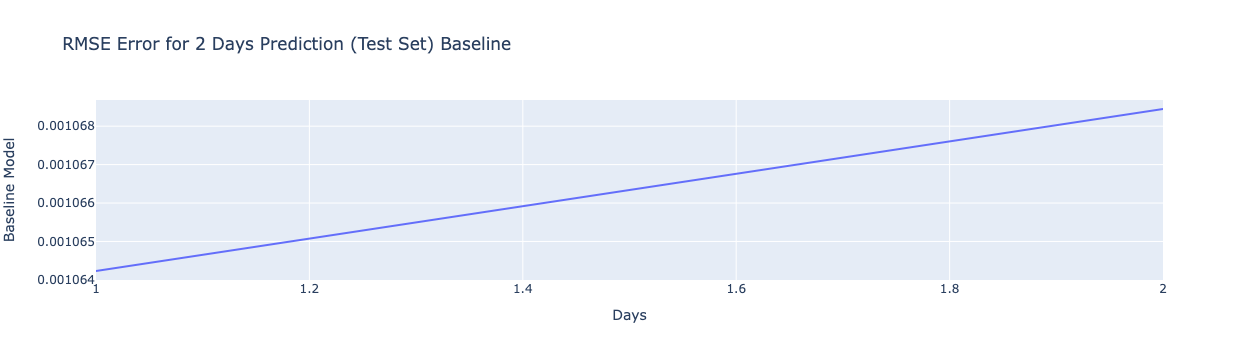

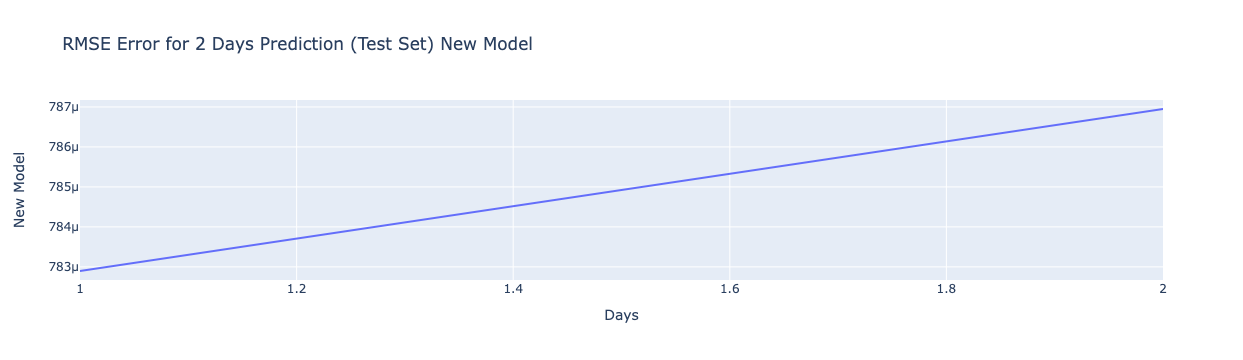

In [32]:
#Short-term performance

short_period = deaths.loc[:, "death_9/14/21" : "death_9/15/21"]
rmse_predictions_short = []
old_rmse_short = []


#Plan: Use actual deaths from previous day as our y and the all the COVID cases history to predict the next day's deaths.
#We will then compare it to the actual deaths that occured that day 
#(i.e. we give our model 9/13/21's deaths + COVID case history and use it to predict 9/14/21's deaths 
#and then compare to the actual 9/14/21's deaths in our dataset to see how far off our model was from the actual deaths

lr_death_new.fit(X = X_death_new, y = (deaths["death_9/13/21"] / deaths["cases_POPESTIMATE2020"].to_numpy()))
pred_y_new = lr_death_new.predict(X_death_new) #prediction for the next day NEW model
pred_y_old = lr_death.predict(X_death) #prediction for the next day OLD model

for col in short_period:
    y_actual = short_period[col]
    y_actual /= deaths["cases_POPESTIMATE2020"].to_numpy() #actual deaths that day
    
    #Get error from actual data deaths and our predicted deaths
    rmse_pred = rmse(y_actual, pred_y_new)
    rmse_predictions_short.append(rmse_pred)
    
    #Fit for next day on our own prediction
    lr_death_new.fit(X = X_death_new, y = pred_y_new)

    #Update our predictions for next iteration
    pred_y_new = lr_death_new.predict(X_death_new)


    #DO SAME FOR OLD MODEL
    
    #Find for old model
    rmse_pred_old = rmse(y_actual, pred_y_old)
    old_rmse_short.append(rmse_pred_old)
    
    #Fit for next day on our own prediction
    lr_death.fit(X = X_death, y = pred_y_old)

    #Update our predictions for next iteration
    pred_y_old = lr_death.predict(X_death)



days = len(short_period.columns) + 1

short_model = pd.DataFrame({"Baseline Model": old_rmse_short,
             "New Model": rmse_predictions_short, 
                            "Days" : np.arange(1, days)})

#short_model = short_model.melt("Days").rename(columns = {"variable": "Model", "value" : "Error"})
#short_model

#sns.lineplot(data = short_model, x = "Days", y = "Error", hue = "Model");
#plt.xticks(np.arange(1, 6))
#plt.title("RMSE Error for 5 Day Prediction (Test Set)");

fig000 = px.line(short_model, x = "Days", y = "Baseline Model",
             title = "RMSE Error for 2 Days Prediction (Test Set) Baseline")
fig000.show()

fig002 = px.line(short_model, x = "Days", y = "New Model",
             title = "RMSE Error for 2 Days Prediction (Test Set) New Model")
fig002.show()

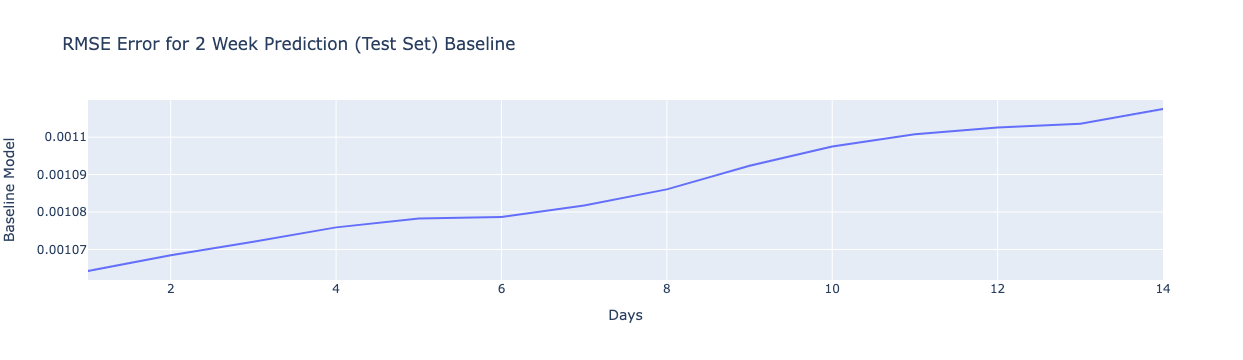

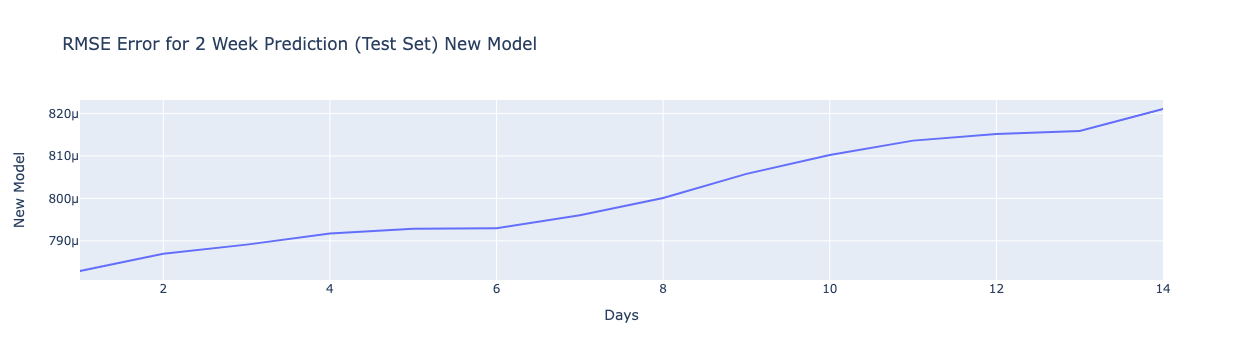

In [33]:
#Performance for Long-Term Errors

long_period = deaths.loc[:, "death_9/14/21" : "death_9/27/21"]
rmse_predictions_long = []
old_rmse_long = []

#Same Plan as Previous --> Start with giving model 9/13/21 deaths to figure out nxt days
lr_death_new.fit(X = X_death_new, y = (deaths["death_9/13/21"] / deaths["cases_POPESTIMATE2020"].to_numpy()))
pred_y_new = lr_death_new.predict(X_death_new) #prediction for the next day NEW model (so 9/14/21 prediction)
pred_y_old = lr_death.predict(X_death) #prediction for the next day OLD model (so 9/14/21 prediction)

for col in long_period:
    y_actual = long_period[col] #actual deaths that day
    y_actual /= deaths["cases_POPESTIMATE2020"].to_numpy() #actual deaths that day
    
    #Get error from actual data deaths and our predicted deaths
    rmse_pred = rmse(y_actual, pred_y_new)
    rmse_predictions_long.append(rmse_pred)
    
    #Fit for next day on our own prediction
    lr_death_new.fit(X = X_death_new, y = pred_y_new)

    #Update our predictions for next iteration
    pred_y_new = lr_death_new.predict(X_death_new)


    #DO SAME FOR OLD MODEL
    
    #Get error for old model's prediction and actual deaths
    old_rmse_pred = rmse(y_actual, pred_y_old)
    old_rmse_long.append(old_rmse_pred)
    
    #Fit for next day on our own prediction
    lr_death.fit(X = X_death, y = pred_y_old)

    #Update our predictions for next iteration
    pred_y_old = lr_death.predict(X_death)

days = len(long_period.columns) + 1
long_model = pd.DataFrame({"Baseline Model":old_rmse_long,
             "New Model": rmse_predictions_long, 
                            "Days" : np.arange(1, days)})

#long_model = long_model.melt("Days").rename(columns = {"variable": "Model", "value" : "Error"})

#sns.lineplot(data = long_model, x = "Days", y = "Error", hue = "Model");
#plt.xticks(np.arange(1, days))
#plt.title("RMSE Error for 2 Week Prediction (Test Set)");

fig00 = px.line(long_model, x = "Days", y = "Baseline Model",
             title = "RMSE Error for 2 Week Prediction (Test Set) Baseline")
fig00.show()

fig02 = px.line(long_model, x = "Days", y = "New Model",
             title = "RMSE Error for 2 Week Prediction (Test Set) New Model")
fig02.show()

In [34]:
print("Improvement in New Model (in Training RMSE) %", (train_death_rmse - train_death_rmse_new)/ train_death_rmse * 100)
print("Improvement in New Model (in Testing RMSE) %", (test_death_rmse - test_death_rmse_new) / test_death_rmse * 100)

Improvement in New Model (in Training RMSE) % 26.00575799986459
Improvement in New Model (in Testing RMSE) % 27.845629141404192


__Our Commentary:__

Just reiterating, our models predicts the NEXT day's COVID deaths given all information time on COVID cases and the deaths for the previous day (i.e. if we're predicting 9/14/21's deaths, our model takes in all COVID cases + 9/13/21's death to predict the net day). In our code above, we are calculating the error/difference from our model's predictions for the NEXT day and comparing it to the ACTUAL deaths that occured that same day. 

As for our model's improved performance, as the duration of days in the prediction increase, our baseline model's RMSE seem to be increasing with a larger slope than our new and improved model, supporting that our new model is more efficient. Based on the RMSE errors plotted, our newer model seems to have a significantly lower RMSE error trend in both the short-term and long-term, thus making it the obvious choice for our main/current model.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6e

Plot and describe the error for both the baseline and improved models as a function of time. In other words, given $x_t$, we wish to predict $\hat{x}_{t+k}$, and plot the error of these predictions for all $k$.

Consider how and why the performance of the model degrades as a function of time using the rate of growth in the error.

<!--
BEGIN QUESTION
name: q6e
points: 0
manual: True
-->

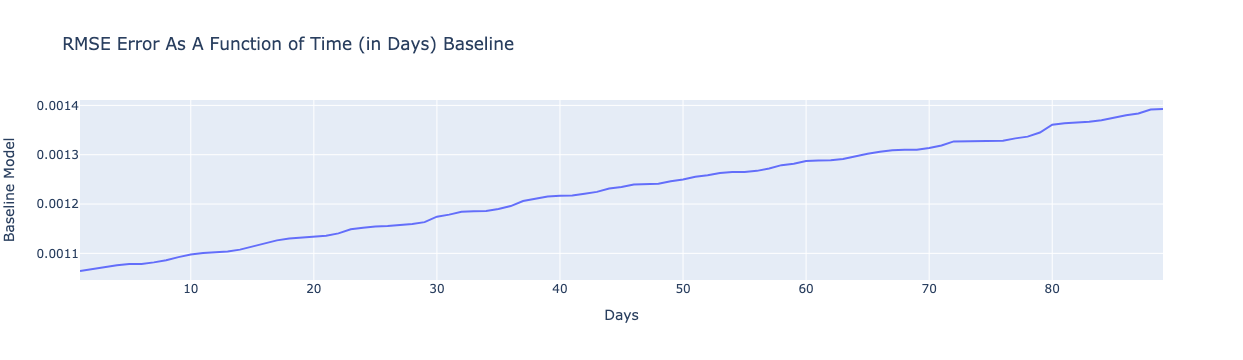

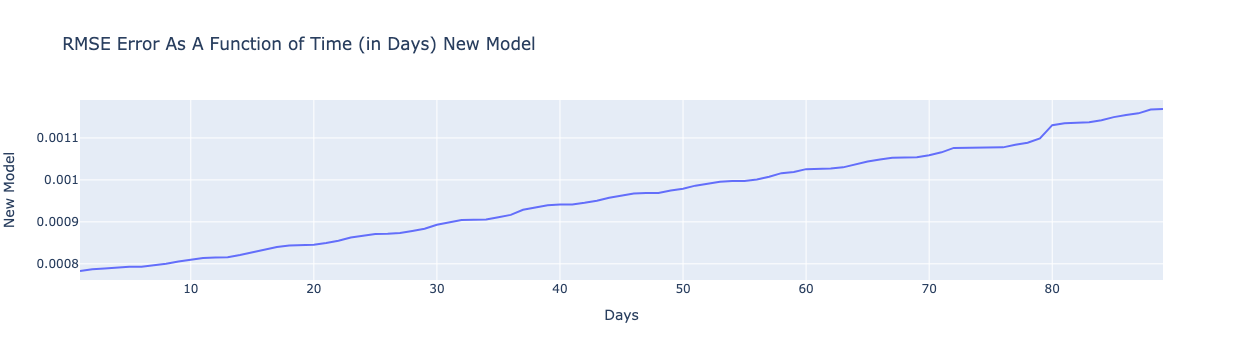

In [35]:
#Performance for Errors as a Function of Time

final_period = deaths.loc[:, "death_9/14/21" : "death_12/11/21"]
rmse_predictions_long = []
old_rmse_long = []

#Same Plan as Previous --> Start with giving model 9/13/21 deaths to figure out nxt days
lr_death_new.fit(X = X_death_new, y = (deaths["death_9/13/21"] / deaths["cases_POPESTIMATE2020"].to_numpy()))
pred_y_new_6e = lr_death_new.predict(X_death_new) #prediction for the next day NEW model (so 9/14/21 prediction)
pred_y_old_6e = lr_death.predict(X_death) #prediction for the next day OLD model (so 9/14/21 prediction)

for col in final_period:
    y_actual = final_period[col] #actual deaths that day
    y_actual /= deaths["cases_POPESTIMATE2020"].to_numpy() #actual deaths that day

    #Get error from actual data deaths and our predicted deaths
    rmse_pred = rmse(y_actual, pred_y_new_6e)
    rmse_predictions_long.append(rmse_pred)
    
    #Fit for next day on our own prediction
    lr_death_new.fit(X = X_death_new, y = pred_y_new_6e)

    #Update our predictions for next iteration
    pred_y_new_6e = lr_death_new.predict(X_death_new)

    
    #DO SAME FOR OLD MODEL
    
    #Get error for old model's prediction and actual deaths
    old_rmse_pred = rmse(y_actual, pred_y_old_6e)
    old_rmse_long.append(old_rmse_pred)
    
    #Fit for next day on our own prediction
    lr_death.fit(X = X_death, y = pred_y_old_6e)

    #Update our predictions for next iteration
    pred_y_old_6e = lr_death.predict(X_death)

days = len(final_period.columns) + 1
final_long_model = pd.DataFrame({"Baseline Model":old_rmse_long,
             "New Model": rmse_predictions_long, 
                            "Days" : np.arange(1, days)})  



#long_model = long_model.melt("Days").rename(columns = {"variable": "Model", "value" : "Error"})

fig = px.line(final_long_model, x = "Days", y = "Baseline Model",
             title = "RMSE Error As A Function of Time (in Days) Baseline")
fig.show()

fig2 = px.line(final_long_model, x = "Days", y = "New Model",
             title = "RMSE Error As A Function of Time (in Days) New Model")
fig2.show()
              
#plt.xticks(np.arange(1, days), rotation = 90)

#plt.title("RMSE Error for 2 Week Prediction (Test Set)");  

__Our Commentary:__

For our baseline model and our current model, our error is increasing as a function of time since originally, our model may have overfitted the data, thus having larger errors in the long-run. The error also seems to grow in a pretty linear manner.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6f

Consider a modification to the model $f(x) = x_{t+1}$ where instead $f(x) = [x_{t+1}, x_{t+2}, ..., x_{t+m}]$ for some $m > 1$. In other words, using the features $x$ that contain past and present quantities, our model *explicitly* predicts values for $m$ days in the future rather than simply the next day (i.e. $m = 1$). 

Train the baseline and improved model using $m = 5$ and $m = 10$. Evaluate and visualize the predictive accuracy of both models.

<!--
BEGIN QUESTION
name: q6f
points: 0
manual: True
-->

In [36]:
# m = 5 --> Create New Y so we can predict 5 days in future
ys_5 = deaths.loc[:, "death_9/12/21":"death_9/16/21"] / deaths[["cases_POPESTIMATE2020"]].to_numpy()

#Get actual deaths for next 5 days to see if prediction correct
ys_actual_next5_days = deaths.loc[:, "death_9/17/21":"death_9/21/21"] / deaths[["cases_POPESTIMATE2020"]].to_numpy()

#Train Baseline Model
lr_death.fit(X = X_death, y = ys_5)
y_pred_old_5 = lr_death.predict(X_death)

#Train New Model
lr_death_new.fit(X = X_death_new, y = ys_5)
y_pred_new_5 = lr_death_new.predict(X_death_new)

#Get RMSE between actual next 5 days death and our model
new_rmse_6fa = rmse(ys_actual_next5_days, y_pred_new_5)
old_rmse_6fa = rmse(ys_actual_next5_days, y_pred_old_5)

#Print out average the RMSE (mean of all 5 days RMSE
print("New Model Overall RMSE (5 day Prediction):", np.mean(new_rmse_6fa))
print("Old Model Overall RMSE (5 day Prediction):", np.mean(old_rmse_6fa))


New Model Overall RMSE (5 day Prediction): 0.0007934438302711625
Old Model Overall RMSE (5 day Prediction): 0.0010790559403640655


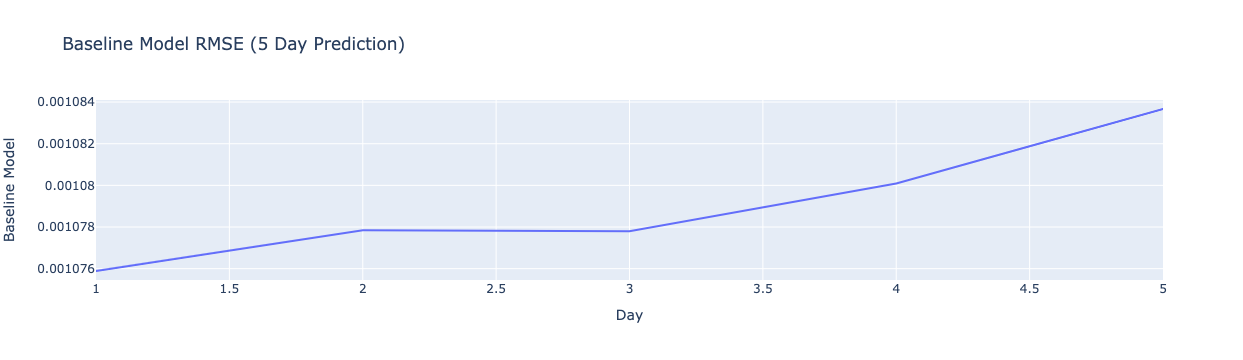

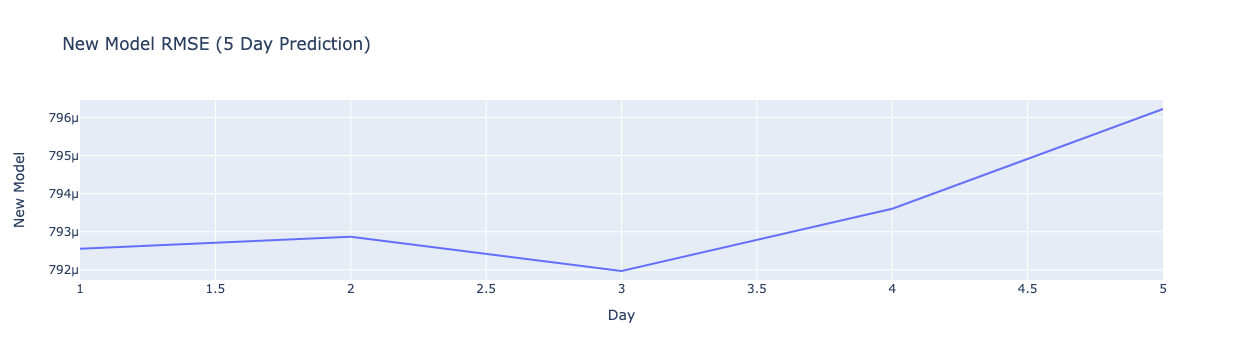

In [37]:
rmse_next_5_day_new = np.array(new_rmse_6fa)
rmse_next_5_day_old = np.array(old_rmse_6fa)

df_6fa_rmse = pd.DataFrame({"Baseline Model": rmse_next_5_day_old, "New Model" : rmse_next_5_day_new, "Day" : np.arange(1, 6)})

fig6faa = px.line(df_6fa_rmse, x = "Day", y = "Baseline Model", title = "Baseline Model RMSE (5 Day Prediction)")
fig6fab = px.line(df_6fa_rmse, x = "Day", y = "New Model", title = "New Model RMSE (5 Day Prediction)")

fig6faa.show()
fig6fab.show()

In [38]:
# m = 10 --> Create New Y so we can predict 10 days in future, same plan as before
ys_10 = deaths.loc[:, "death_9/12/21":"death_9/21/21"] / deaths[["cases_POPESTIMATE2020"]].to_numpy()
ys_actual_next10_days = deaths.loc[:, "death_9/22/21":"death_10/1/21"] / deaths[["cases_POPESTIMATE2020"]].to_numpy()

#Train Baseline Model
lr_death.fit(X = X_death, y = ys_10)
y_pred_old_10 = lr_death.predict(X_death)

#Train New Model
lr_death_new.fit(X = X_death_new, y = ys_10)
y_pred_new_10 = lr_death_new.predict(X_death_new)

#Get RMSE
new_rmse_6fb = rmse(ys_actual_next10_days, y_pred_new_10)
old_rmse_6fb = rmse(ys_actual_next10_days, y_pred_old_10)

#Print out average the RMSE (mean of all 5 days RMSE
print("New Model Overall RMSE (10 day Prediction):", np.mean(new_rmse_6fb))
print("Old Model Overall RMSE (10 day Prediction):", np.mean(old_rmse_6fb))


New Model Overall RMSE (10 day Prediction): 0.000815597355641565
Old Model Overall RMSE (10 day Prediction): 0.0011049575317816375


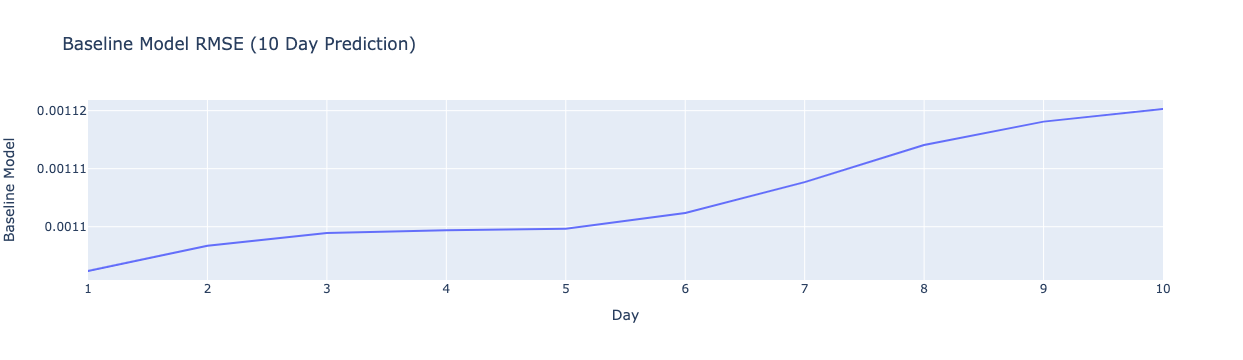

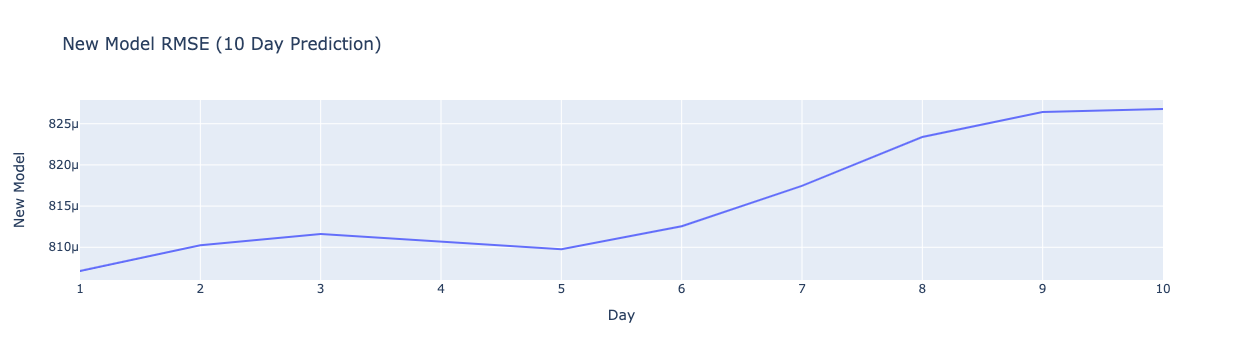

In [39]:
rmse_next_10_day_new = np.array(new_rmse_6fb)
rmse_next_10_day_old = np.array(old_rmse_6fb)

df_6fb_rmse = pd.DataFrame({"Baseline Model": rmse_next_10_day_old, "New Model" : rmse_next_10_day_new, "Day" : np.arange(1, 11)})
#final_df_6f_rmse = df_6f_rmse.melt("Day").rename(columns = {"variable" : "Model Type", "value" : "RMSE"})

fig6fba = px.line(df_6fb_rmse, x = "Day", y = "Baseline Model", title = "Baseline Model RMSE (10 Day Prediction)")
fig6fbb = px.line(df_6fb_rmse, x = "Day", y = "New Model", title = "New Model RMSE (10 Day Prediction)")

fig6fba.show()
fig6fbb.show()

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [40]:
grader.check_all()

q1a results: All test cases passed!

q1d results: All test cases passed!

q1e results: All test cases passed!

q5b results: All test cases passed!

q5d results: All test cases passed!

q5f results: All test cases passed!

q5g results: All test cases passed!

q5i results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [23]:
# Save your notebook first, then run this cell to export your submission.
grader.export()

There was an error generating your LaTeX
Showing concise error message
[7]
! Missing $ inserted.
<inserted text> 
                $
l.545 \$ = E(((g\^{}\{`\}(x) + \epsilon
                                       \^{}\{'\}) - \hat{y})\^{}2)\$
? 
! Emergency stop.
<inserted text> 
                $
l.545 \$ = E(((g\^{}\{`\}(x) + \epsilon
                                       \^{}\{'\}) - \hat{y})\^{}2)\$
Output written on notebook.pdf (7 pages).
Transcript written on notebook.log.

